# Imports

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

from scipy import stats 

from sklearn.neighbors import (NearestNeighbors, 
                               KNeighborsRegressor)

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.experimental import enable_halving_search_cv 

from sklearn.model_selection import (train_test_split, 
                                     learning_curve,
                                     cross_validate,
                                     cross_val_score,
                                     RandomizedSearchCV,
                                     GridSearchCV,
                                     HalvingGridSearchCV)

from sklearn.tree import (DecisionTreeRegressor, 
                          ExtraTreeRegressor)

from sklearn.ensemble import (RandomForestRegressor, 
                              IsolationForest)

from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import (SelectKBest, 
                                       f_regression)

from sklearn.preprocessing import (MinMaxScaler, 
                                   RobustScaler, 
                                   StandardScaler, 
                                   MaxAbsScaler,
                                   FunctionTransformer,
                                   OneHotEncoder,
                                   PolynomialFeatures,
                                   OrdinalEncoder) 

from sklearn.metrics import (r2_score,
                             mean_squared_error, 
                             mean_absolute_error,
                             SCORERS)

from matplotlib import pyplot as plt
import seaborn as sns

from eli5.sklearn import PermutationImportance
import eli5

In [3]:
warnings.filterwarnings('ignore') 

In [4]:
sns.set_style('darkgrid')

In [5]:
df = pd.read_csv('kc_house_data.csv')

In [6]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Feature Engineering

## Ajustes dos tipos de dados

In [7]:
#df.drop('id', axis = 1, inplace = True)

df.date = pd.to_datetime(df.date)
df.waterfront = df.waterfront.astype('bool')
df.condition = df.condition.astype('category')
df.grade = df.grade.astype('category')
df.view = df.view.astype('category')
df.zipcode = df.zipcode.astype('object')

# df.yr_renovated = df.yr_renovated.replace(0, np.nan)
# df.yr_renovated = pd.to_datetime(df.yr_renovated, format = '%Y').dt.year

## Criação de features

In [8]:
### Feature Engineering ###

df['bedbath']    = df.apply(lambda x: x.bedrooms/x.bathrooms if x.bathrooms > 0 else x.bedrooms, axis = 1)
df['renovated']  = df.yr_renovated.apply(lambda x: 1 if x>0 else 0)
df['flr_living'] = df.floors*df.sqft_living
df['livinglot']  = df.sqft_living/df.sqft_lot
df['lastbuild']  = df.apply(lambda x: (2022 - x.yr_renovated) if x.yr_renovated > 0 else (2022 - x.yr_built), axis =1)

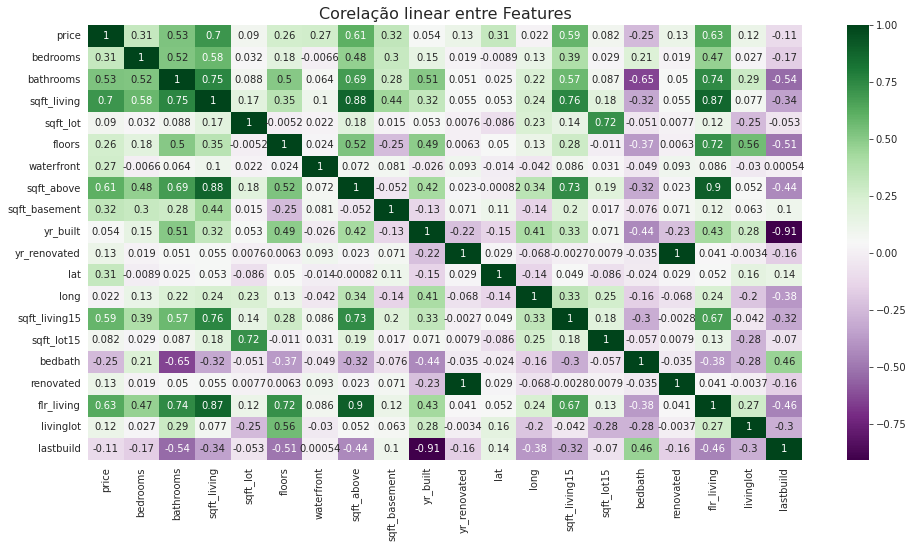

In [9]:
plt.figure(figsize = (16,8))
sns.heatmap(df.drop('id', axis = 1).corr(), annot = True, cmap = 'PRGn')
plt.title("Corelação linear entre Features", fontsize = 16)
plt.show()

# Data Preparation

In [10]:
X = df.drop(['zipcode','price','date', 'yr_renovated','yr_built', 'id','sqft_lot'], axis = 1)
y = df.price

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle = True)

In [12]:
X_train

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,bedbath,renovated,flr_living,livinglot,lastbuild
5945,4,2.25,1810,2.0,False,0,3,7,1810,0,47.4362,-122.187,1660,9240,1.777778,0,3620.0,0.195887,61
8423,3,2.50,1600,2.0,False,0,4,7,1600,0,47.4034,-122.187,1720,3605,1.200000,0,3200.0,0.573888,30
13488,4,2.50,1720,2.0,False,0,3,8,1720,0,47.2704,-122.313,1870,7455,1.600000,0,3440.0,0.199120,28
20731,2,2.25,1240,2.0,False,0,3,7,1150,90,47.5321,-122.073,1240,750,0.888889,0,2480.0,1.758865,13
2358,3,2.00,1280,1.0,False,0,3,7,1280,0,47.3715,-122.074,1590,8071,1.500000,0,1280.0,0.095837,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,3,1.50,1000,1.0,False,0,3,7,1000,0,47.7144,-122.319,1000,6947,2.000000,0,1000.0,0.144634,75
21575,3,2.50,3087,2.0,False,0,3,8,3087,0,47.2974,-122.349,2927,5183,1.200000,0,6174.0,0.617153,8
5390,3,2.50,2120,2.0,False,0,3,7,2120,0,47.6810,-122.032,1690,2650,1.200000,0,4240.0,0.443515,18
860,1,0.75,380,1.0,False,0,3,5,380,0,47.4810,-122.323,1170,15000,1.333333,0,380.0,0.025333,59


## Feature Selection

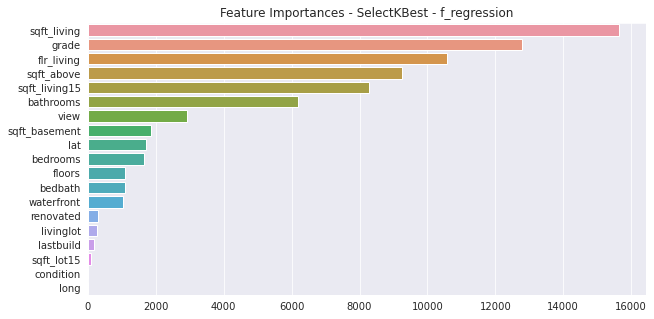

In [13]:
skbest = SelectKBest(f_regression, k = 'all')
skbest.fit_transform(X_train, y_train)
s1 = pd.Series(data = skbest.scores_, index = skbest.feature_names_in_).sort_values(ascending = False)
plt.figure(figsize=(10,5))
sns.barplot(x = s1.values, y=s1.index, orient = 'h')
plt.title('Feature Importances - SelectKBest - f_regression')
plt.show()

Possíveis K valores: 7, 10, 13.

## Verificação de outliers 

In [14]:
#Método IQR

for col in X_train.select_dtypes(include = 'number').drop(['lat','long', 'renovated'], axis = 1).columns:
    mean   = X_train[col].mean()
    std    = X_train[col].std()
    cutoff = 3*stats.iqr(X_train[col])
    outs   = (X_train[(X_train[col] < mean - cutoff) | (X_train[col] > mean + cutoff)]).shape[0]
    print(f'{col}: {outs}')

bedrooms: 51
bathrooms: 27
sqft_living: 90
floors: 0
sqft_above: 78
sqft_basement: 54
sqft_living15: 50
sqft_lot15: 1130
bedbath: 294
flr_living: 57
livinglot: 461
lastbuild: 0


In [16]:
#Isolation Forest

iso_forest = IsolationForest()
outliers = iso_forest.fit_predict(X_train.drop(['lat','long', 'renovated'], axis =1))
print(f'Possíveis outliers: {(outliers == -1).sum()}')

Possíveis outliers: 1496


In [99]:
# Remoção de outliers por Isolation Forest
X_train_if, y_train_if = X_train[(outliers!=-1)], y_train[(outliers!=-1)]

A remoção dos possíveis outliers acabou por degradar um pouco a performance do modelo.

# Criação de Pipelines de Processamento e Modelagem

In [17]:
num_pipe = Pipeline(steps=[('log', FunctionTransformer(np.log1p)),
                           ('scaler', MinMaxScaler())
                          ])

In [18]:
ct = ColumnTransformer(transformers=[
        ('numeric', num_pipe, ['sqft_living','floors', 'sqft_living15','sqft_lot15', 'flr_living']),
        ], remainder = 'passthrough')

Adaptação do Column Transformer para ser aplicado após a seleção de features.

## Teste de Modelos Baseline

In [19]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

Função R² ajustado

In [20]:
mean_prediction_vector = (df.price.mean()*np.ones(y_test.shape[0]))

print(f'R2: {r2_score(y_test, mean_prediction_vector)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(y_test, mean_prediction_vector)),2)}')

R2: -0.0004121721171661541
RMSE: 386845.29


## Model Selection

In [ ]:
scalers    = [StandardScaler(), RobustScaler(), MinMaxScaler()]
regressors = [LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor(), ExtraTreeRegressor(), KNeighborsRegressor()]
scores     = []
for scaler in scalers:
    for regressor in regressors:
        pipe = Pipeline(steps = [('preprocessor', ct),
                                 ('modeling', regressor)])
        
        score = cross_validate(pipe, X = X_train, y = y_train, scoring = ['r2', 'neg_mean_squared_error'], cv = 5)
        #adj_score = adjustedR2(score, X_train.shape[0], X_train.shape[1])
        print(regressor, scaler, score['test_r2'].mean(), np.sqrt(-score['test_neg_mean_squared_error'].mean()))

Melhor modelo observado: Random Forest Regressor, seguido pela Regressão Linear Simples

In [21]:
pipes = {'LinearRegression': Pipeline(steps = [('preprocessor', ct),
                                     ('poly', PolynomialFeatures(degree = 2)),
                                     ('modeling', LinearRegression())
                             ]),
         'RandomForest': Pipeline(steps = [('preprocessor', ct),
                                           ('modeling', RandomForestRegressor())
                           ])
        }

In [24]:
def model_validation(pipes):
    
    for model, pipe in pipes.items():
        start = datetime.now()
        scores = cross_validate(pipe, X=X_train, y=y_train, scoring = ['r2','neg_mean_squared_error'], cv=5)
        score = adjustedR2(scores['test_r2'].mean(), X_train.shape[0], X_train.shape[1])
        end = datetime.now()
        print(model)
        print('Time: ',end-start)
        print('Test_R2:  ', score, scores['test_r2'].std())
        print('Test_MSE:  ', np.sqrt(-scores['test_neg_mean_squared_error'].mean()), np.sqrt(scores['test_neg_mean_squared_error'].std()))
        print()
        
model_validation(pipes)

LinearRegression
Time:  0:00:01.098049
Test_R2:   0.8009357657008463 0.022726175605066026
Test_MSE:   159907.28733220865 39760.20369622171

RandomForest
Time:  0:01:05.468292
Test_R2:   0.8745599491962069 0.009748033914269814
Test_MSE:   127830.75999261797 51990.050044359035



In [25]:
reglin_pipe = pipes['LinearRegression']
rf_pipe = pipes['RandomForest']

In [26]:
def lcurves(pipe):

        lc = learning_curve(pipe, X_train, y_train, cv = 5, shuffle = True, scoring = 'r2')
        plt.figure(figsize=(7,4))
        sns.lineplot(x=lc[0], y=np.mean(lc[1], axis = 1), label = 'train', marker = "X")
        sns.lineplot(x=lc[0], y=np.mean(lc[2], axis = 1), label = 'validation', marker = 'X')
        plt.title(f'Learning Curves - {str(rf_pipe.named_steps.modeling).split(sep="(")[0]}', fontsize = 12)
        plt.legend()

In [ ]:
for pipe in pipes:
    lcurves(pipe)

A diferença entre o score de treino e validação revela um indício de overfitting no modelo Random Forest.

O mesmo não ocorre no modelo de Regressão Linear. Como esse modelo parece não ter muito overfitting, não há necessidade de testar versão com regularização para melhorar as métricas (Lasso, Ridge, ElasticNet).

Há possibilidade de melhorar o modelo Random Forest reduzindo o overfitting com tunagem de hiperparâmetros

# Tunagem de Hiperparâmetros

In [28]:
rf_pipe['modeling'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [30]:
grid = {'modeling__max_depth':[20, 25,30, None],
        'modeling__max_features':['auto',3,5,10,15],
        'modeling__min_samples_split':[2,5,10],
        'modeling__n_estimators':[100,300],
        'modeling__min_samples_leaf':[1,2,3,4,5]
        }

In [31]:
def hgridsearch(scoring = 'r2'):
    gsearch = HalvingGridSearchCV(rf_pipe, grid, cv = 5, scoring = scoring)
    gsearch.fit(X=X_train, y = y_train)
    return gsearch.best_params_, gsearch.best_score_

In [32]:
grid_result = hgridsearch()

In [35]:
grid_result[0]

{'modeling__max_depth': 20,
 'modeling__max_features': 'auto',
 'modeling__min_samples_leaf': 2,
 'modeling__min_samples_split': 2,
 'modeling__n_estimators': 300}

In [36]:
grid_result[1]

0.8737522448778042

# Testagem Final do Modelo

In [37]:
rf_pipe = Pipeline(steps = [('preprocessor', ct),
                            ('modeling', RandomForestRegressor(max_depth= 20,
                                                             max_features= 'auto',
                                                             min_samples_leaf= 2,
                                                             min_samples_split= 2,
                                                             n_estimators= 300))
                                                                                       ])

In [ ]:
rf_pipe.fit(X_train, y_train)

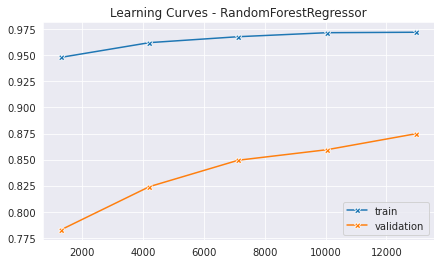

In [40]:
lcurves(rf_pipe)

A inclinação da curva de validação e a tendência da curva de treino no gráfico acima indicam que o aumento de amostras no dataset pode contribuir para a redução de overfitting.

In [44]:
pred = rf_pipe.predict(X_test)
print('R2: ', r2_score(y_test, pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, pred)))


R2:  0.8702331128567312
RMSE:  139325.23232715024


# Feature Importances

### Permutation Importance

In [46]:
perm = PermutationImportance(rf_pipe)

In [ ]:
perm.fit(X_test, y_test)

In [48]:
p_imp = pd.Series(perm.feature_importances_, index = X_test.columns)
p_imp.sort_values(ascending = False, inplace = True)

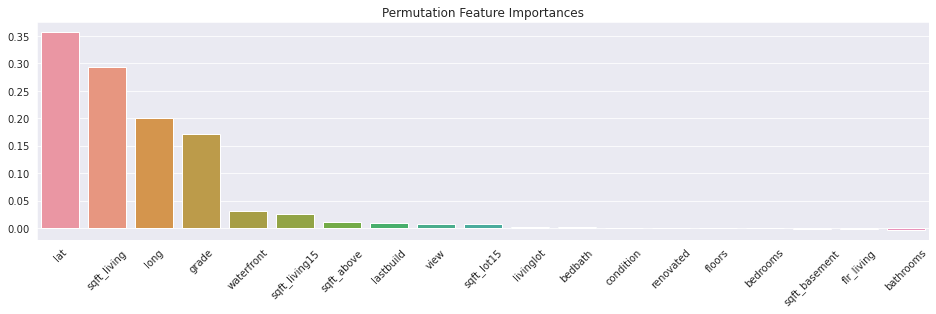

In [49]:
plt.figure(figsize=(16,4))
sns.barplot(x=p_imp.index, y= p_imp.values)
plt.xticks(rotation = 45)
plt.title('Permutation Feature Importances')
plt.show()

In [50]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.3565 ± 0.0068,lat
0.2933 ± 0.0387,sqft_living
0.2008 ± 0.0203,long
0.1712 ± 0.0181,grade
0.0318 ± 0.0018,waterfront
0.0264 ± 0.0037,sqft_living15
0.0104 ± 0.0010,sqft_above
0.0087 ± 0.0018,lastbuild
0.0080 ± 0.0010,view
0.0076 ± 0.0011,sqft_lot15


### Random Forest Feature Importances

In [ ]:
np.argsort()

In [57]:
fi_indices = rf_pipe['modeling'].feature_importances_.argsort()

In [54]:
rf_pipe['modeling'].feature_importances_

array([0.26130003, 0.00067163, 0.03070403, 0.01390764, 0.00854573,
       0.00159394, 0.00784086, 0.03089895, 0.01337075, 0.00257517,
       0.33526568, 0.01777152, 0.00503901, 0.16403598, 0.07282943,
       0.00600703, 0.00150711, 0.01141751, 0.01471801])

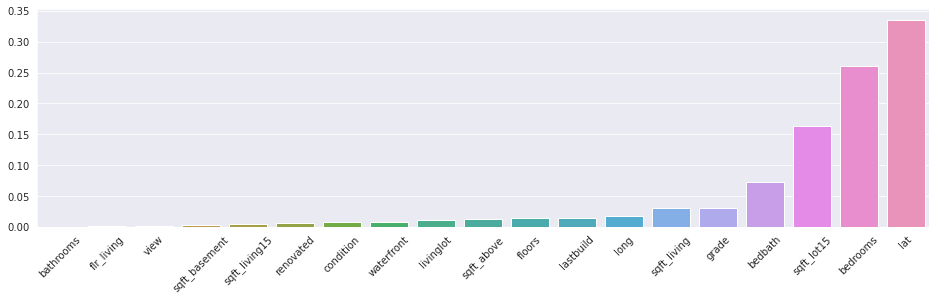

In [56]:
plt.figure(figsize=(16,4))
sns.barplot(x=X_train.columns[fi_indices], y=rf_pipe.named_steps['modeling'].feature_importances_[fi_indices])
plt.xticks(rotation = 45)
plt.show()